WIP solution guide for w1d4 by Chris MacLeod

Think about loading in architecture here. How do we compose things nicely? How do we run things nicely?
We can batch through the network if we apply the right transforms to the right slices first.

Notes:
- Logit 50 is alligator? Is this list right? https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [175]:
import einops
import matplotlib.pyplot as plt
import torch
import tqdm
from torchvision import models
from torchvision.utils import make_grid
from torchvision.transforms import ColorJitter, RandomAffine, Compose
import pandas as pd

plt.rcParams["figure.figsize"] = (12, 12)

# CM: The channels are in RGB order? How to find this out if you don't know?
# CM: why Resnet? Worth comparing others?
model = models.resnet34(pretrained=True)
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)


def imshow(img, fig=None):
    if fig is None:
        fig, ax = plt.subplots()
    if len(img.shape) == 4:
        img = img.squeeze(0)
    # CM: are these labeled wrong? I thought height comes before width?
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    # CM: why do we need detach here?
    ax.imshow(img_reshaped.detach())
    ax.set(xticks=[], yticks=[])


cpu


In [165]:
torch.sigmoid(torch.tensor([0, 0.5, 1]))

tensor([0.5000, 0.6225, 0.7311])

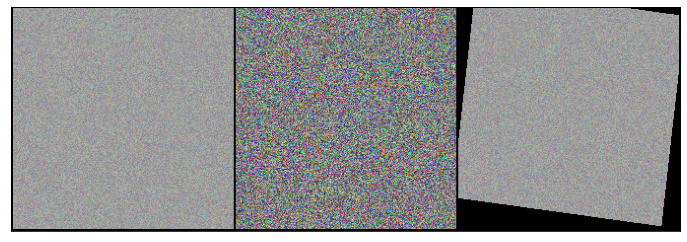

In [166]:
from torch import nn

class LearnableImage(nn.Module):
    IMAGE_SHAPE = (1, 3, 224, 224)

    def __init__(self):
        super().__init__()
        self.params = None
        self.layers = None
        self.target_logit = 50

    def forward(self):
        return self.layers(self.params)

    def loss(self, logits):
        return -logits[self.target_logit]

# Q: what will the range be before the sigmoid? After the sigmoid?

class UniformInit(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.rand(self.IMAGE_SHAPE))
        self.layers = nn.Sequential(nn.Sigmoid())


class NormalInit(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.randn(self.IMAGE_SHAPE))
        self.layers = nn.Sequential(nn.Sigmoid())


class DataAugmentation(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.rand(self.IMAGE_SHAPE))
        self.layers = nn.Sequential(
            nn.Sigmoid(),
            RandomAffine(10, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=5)
        )

def show_experiments():
    imshow(make_grid(torch.concat([e() for e in experiments])))

experiments = [UniformInit(), NormalInit(), DataAugmentation()]
show_experiments()



  0%|          | 0/40 [00:00<?, ?it/s]

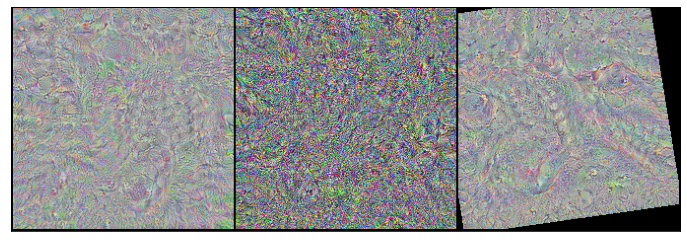

In [173]:
n_iterations = 40
# American Alligator: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

model.requires_grad_(False)
optim = torch.optim.Adam([p for e in experiments for p in e.parameters()], lr=0.05)

all_images = torch.zeros((n_iterations, len(experiments), 3, 224, 224))
all_losses = torch.zeros((n_iterations, len(experiments))).float()

for i in tqdm.notebook.trange(n_iterations):
    optim.zero_grad()
    batch = torch.concat([e() for e in experiments])
    all_images[i] = batch.detach()
    logits = model(batch) # (batch, output_classes)
    total_loss = 0
    for j, e in enumerate(experiments):
        loss = e.loss(logits[j])
        total_loss += loss
        all_losses[i, j] = float(loss) # detach
    total_loss.backward()
    optim.step()

show_experiments()

In [190]:
from ipywidgets import widgets, interact
def show_iteration(iteration_num):
    imshow(make_grid(all_images[iteration_num]))

interact(show_iteration, iteration_num=widgets.IntSlider(
    value=0,
    min=0,
    max=n_iterations-1,
    step=1
));

interactive(children=(IntSlider(value=0, description='iteration_num', max=39), Output()), _dom_classes=('widge…

<AxesSubplot:title={'center':'Loss vs Iterations'}>

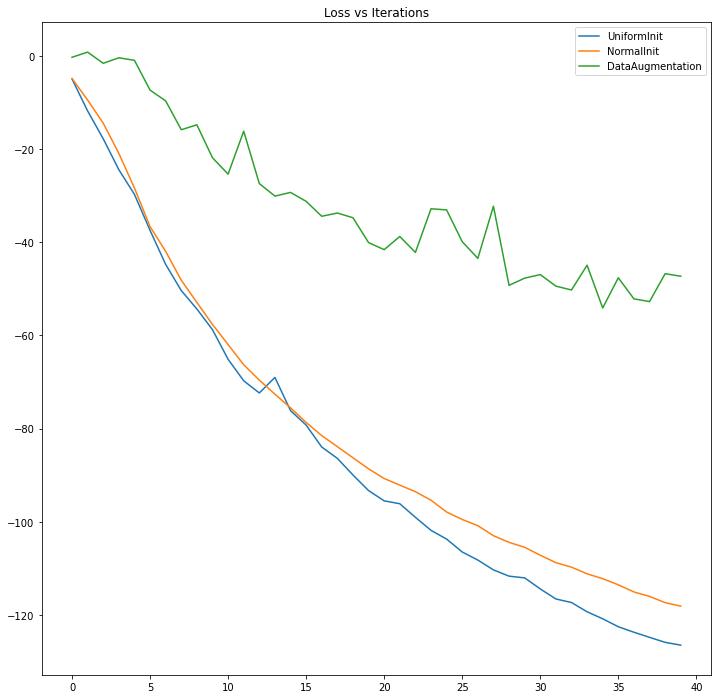

In [191]:
df = pd.DataFrame(all_losses.numpy(), columns=[e.__class__.__name__ for e in experiments])
df.plot(title='Loss vs Iterations')

In [81]:
# CM TODO: this is not explained well at all in the instructions
# Should it really make it red?
import numpy as np

# w1d4.py did this but I don't know why
class LinearDecorrelateColor(nn.Module):
    def __init__(self):
        color_correlation_svd_sqrt = np.asarray(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]])
        max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))
        self.mat = torch.tensor(color_correlation_svd_sqrt / max_norm_svd_sqrt, dtype=torch.float32)

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)

# This seems to follow the instructions    
class LinearDecorrelateColor2(nn.Module):
    def __init__(self):
        self.mat = torch.tensor(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]], dtype=torch.float32)

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)

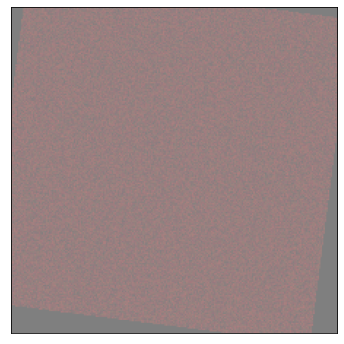

In [82]:

# Tip: these expect CHW or BCHW format, which we are already using.
# Tip: if you get an error about im_size or expecting Image but got Tensor, this may indicate an old version of torchvision.
# I tested this on torchvision 0.10.1.
transform = Compose([
    ColorJitter(),
    ,
    LinearDecorrelateColor2(),
    nn.Sigmoid(),
])
img = torch.rand((1, 3, 224, 224))
imshow(transform(img))

In [83]:
scale = torch.load('result.pt')
scale.shape

torch.Size([3, 224, 113])

In [96]:
# CM: how many iterations is best to see something? 20? Or stop when we're not changing by much?
import tqdm

def random_image():
    return torch.rand((1, 3, 224, 224)).requires_grad_(True)

# CM: do we just mess around with init_sd or is there a way to pick it?
def freq_image(init_sd=0.1):
    spectra = torch.view_as_complex(init_sd * torch.randn((1, 3, 224, 113, 2)))
    # Tip: Specifying s also determines the dimensions to FFT over.
    # So irfft2 and irfftn are the same here
    # CM: does the normalization mode really matter here?
    img2 = torch.fft.irfft2(scale * spectra, s=(224, 224)).float()
    print(img2.abs().mean(), img2.max(), img2.std())
    return img2.requires_grad_(True)

#img = random_image()
img = freq_image()




tensor(0.1081) tensor(0.4998) tensor(0.1331)


  0%|          | 0/40 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0872) tensor(0.4261) tensor(0.1091)


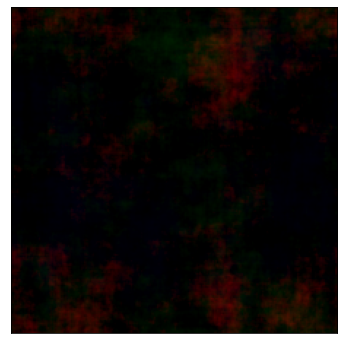

In [97]:
imshow(LinearDecorrelateColor()(freq_image()))

In [98]:
# CM: should we be trying to get these into some certain range
# so the softmax doesn't squish them too bad?
img.min(), img.max()

(tensor(-1.5582, grad_fn=<MinBackward1>),
 tensor(1.7068, grad_fn=<MaxBackward1>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


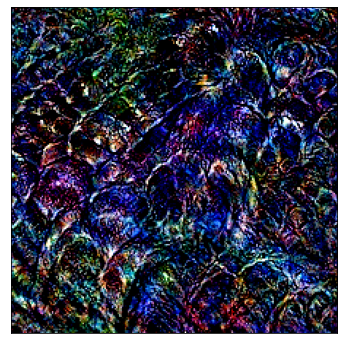

In [99]:
imshow(img)